In [22]:
import torch
import pandas as pd
import numpy as np

from datetime import datetime
from matplotlib import pyplot as plt

from utils.instruments import Stock, RiskFactor
from utils.data_handler import YahooDataHandler
from models.ar import AR
from models.garch import GARCH


%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

ImportError: cannot import name 'INITIAL_VARIANCE_GARCH_OBSERVATIONS' from 'utils.config' (/Users/axelnilsson/Desktop/Abacus/src2/utils/config.py)

In [5]:
ydh = YahooDataHandler()

In [6]:
# List of shares:
tickers = ["GS"]
instruments = []

# Start and end dates.
start = datetime.strptime("2010-05-01", r"%Y-%m-%d")
end = datetime.strptime("2023-06-01", r"%Y-%m-%d")

for ticker in tickers:
    price_history = ydh.get_price_history(ticker, start, end)

    identifier = f"{ticker}_RF"
    risk_factors = [RiskFactor(identifier, price_history)]

    stock = Stock(identifier=ticker, risk_factors=risk_factors)
    instruments.append(stock)

[*********************100%***********************]  1 of 1 completed


Finanical data (Normalized and Stationary)

In [7]:
for instrument in instruments:
    for risk_factor in instrument.risk_factors:
        data = risk_factor.price_history.log_returns

In [8]:
xom_process = AR(data)
xom_process.calibrate()

In [9]:
xom_process._order
xom_process.parameters

[tensor([-0.0643,  0.0694, -0.0192]), tensor(0.0003), tensor(0.0181)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3


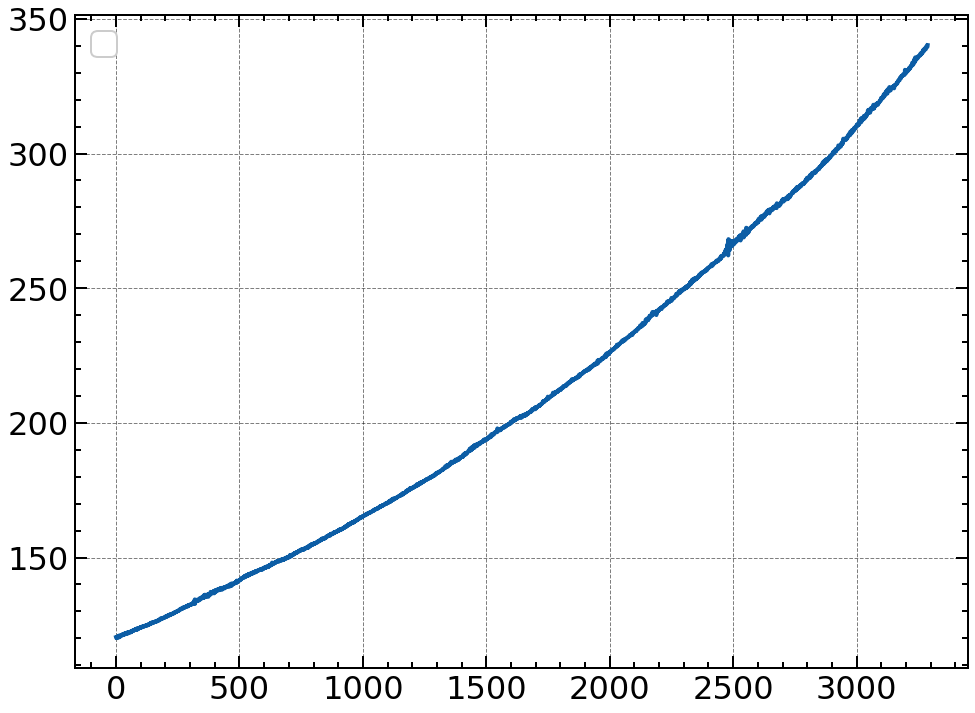

In [10]:
S0 = torch.tensor(120.16422271728516)

#print(risk_factor.price_history.mid_history[0])
#plt.plot(torch.cumprod(xom_process._predictions, dim=0) * S0 + S0, label="Prediction")



#plt.plot(risk_factor.price_history.mid_history.values, label="Actual")
#plt.plot(torch.exp(torch.cumsum(torch.tensor(risk_factor.price_history.log_returns), dim=0)) * S0, label="Transformed")
#plt.plot(torch.exp(torch.cumsum(xom_process._predictions, dim=0)) * S0, label="Predictions")

#plt.plot(risk_factor.price_history.log_returns.values)
#plt.plot(xom_process._predictions)
plt.plot(torch.exp(torch.cumsum(xom_process._predictions, dim=0)) * S0)
print(xom_process._order)


plt.legend()
plt.show()

In [11]:
from statsmodels.tsa.ar_model import AutoReg

m = AutoReg(data, 10)
m.fit()

/Users/axelnilsson/Desktop/Abacus/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/Users/axelnilsson/Desktop/Abacus/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[]

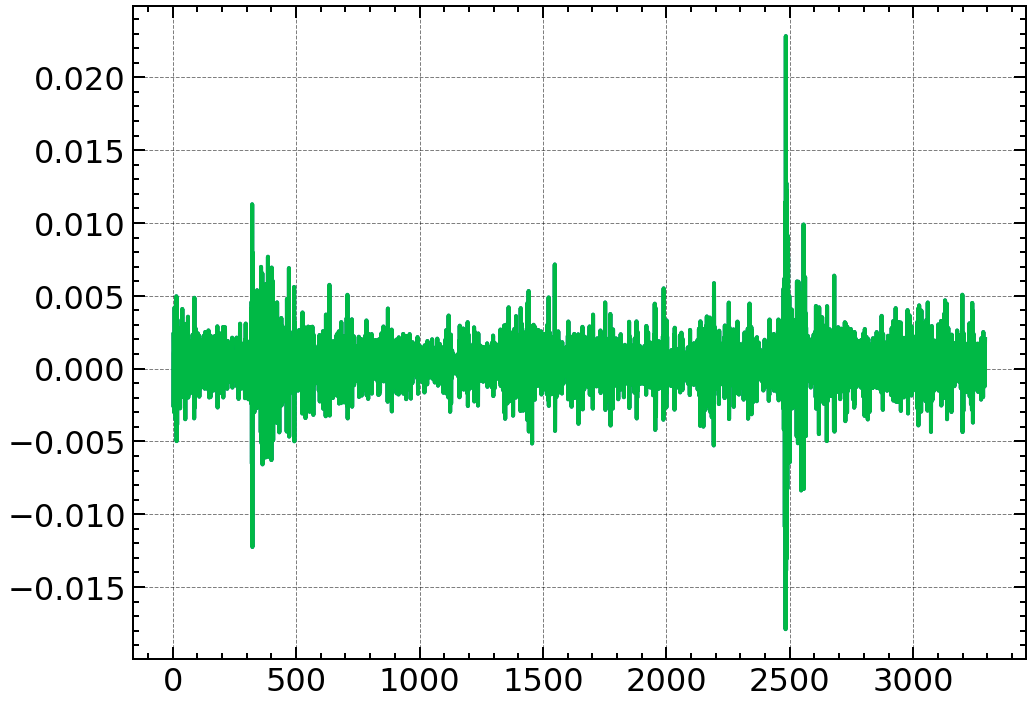

In [12]:
signal = np.ones(200) + np.random.randn(200)
sig_model = AR(data)
sig_model.calibrate()


sig_model_predictions = torch.zeros(sig_model._number_of_observations)
sig_model_predictions[0:sig_model._order] = torch.nan
sig_model_predictions[sig_model._order:] = sig_model._predictions

act_model = AutoReg(data, sig_model._order)
mod_model = act_model.fit()



plt.plot(sig_model_predictions)
plt.plot(act_model.predict(mod_model.params, 0))

plt.plot()



In [13]:
sig_model.mse

tensor(0.0003)

Non-financial data

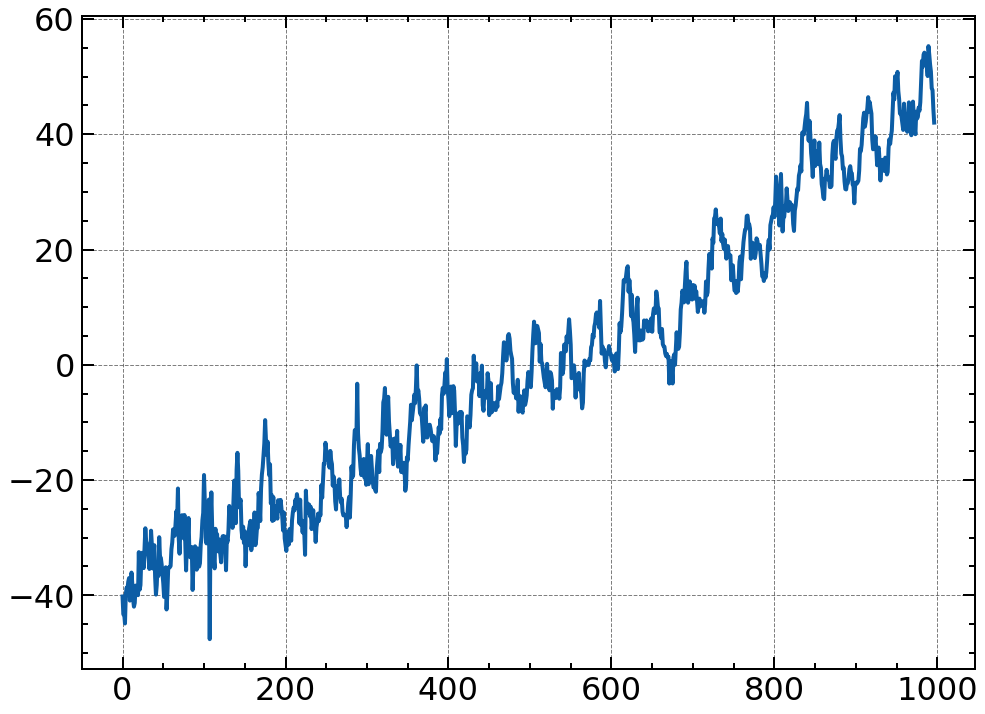

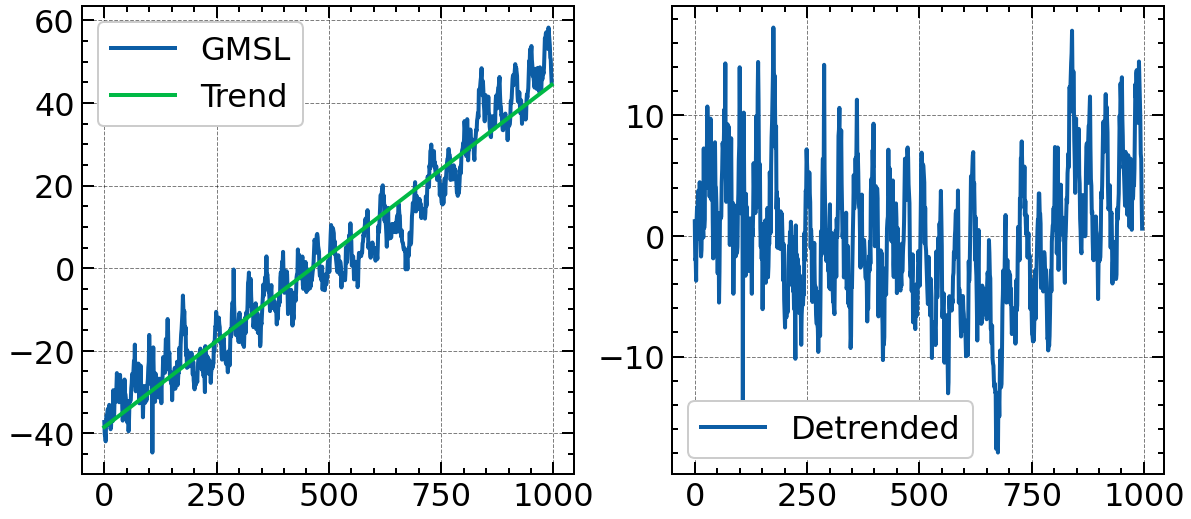

In [14]:
df = pd.read_csv("data.csv")
(df["GMSL"]- (df["GMSL"].mean())).plot()
number_of_observations = len(df)
Y = np.array(df["GMSL"])
X = np.stack([np.ones(number_of_observations), np.array(df.index)]).T
beta = np.linalg.inv((X.T @ X)) @ X.T @ Y
def trend(t: np.array, beta: np.array = beta) -> np.array:
    n = len(t)
    H = np.stack([np.ones(n), t]).T
    return H @ beta
fig, ax = plt.subplots(1,2)
ax[0].plot(df.index, df["GMSL"])
ax[0].plot(df.index, trend(df.index))
ax[0].legend(["GMSL", "Trend"])
ax[1].plot(df.index, df["GMSL"]-trend(df.index))
ax[1].legend(["Detrended"])
fig.set_size_inches(9.7, 4.3)
plt.show()

In [15]:
df_training = (df["GMSL"]-trend(df.index)).iloc[200:]
data_tensor = torch.tensor([value for value in df_training])

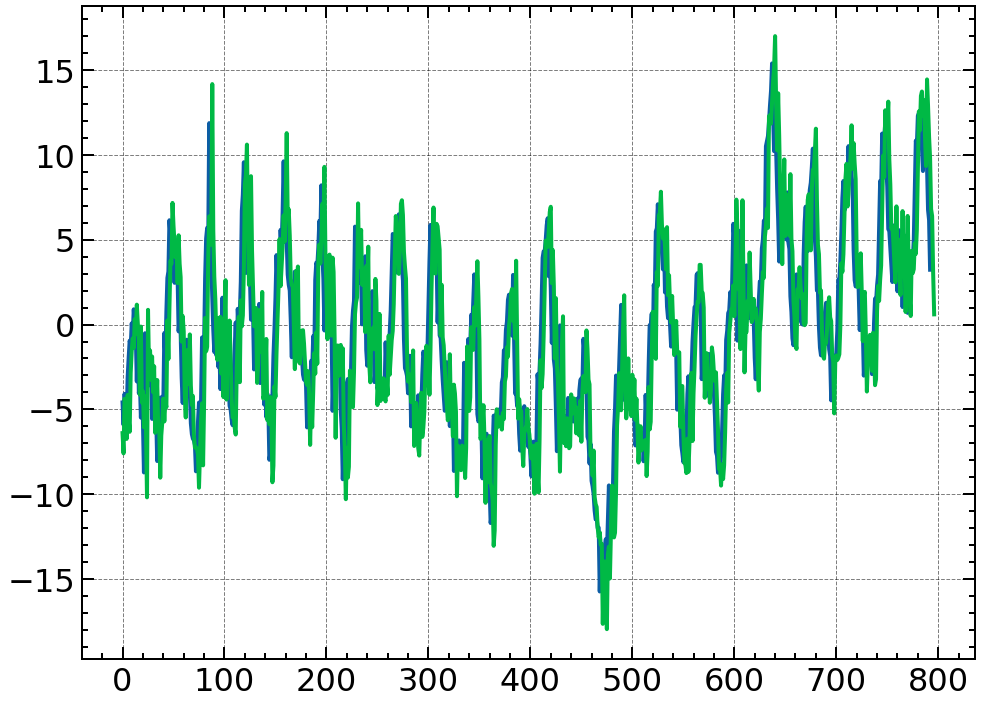

In [16]:
model = AR(df_training)
model.calibrate()
predictions = model._Q @ model._R @ model._solution
model.mse
plt.plot(predictions)
plt.plot(df_training.values)

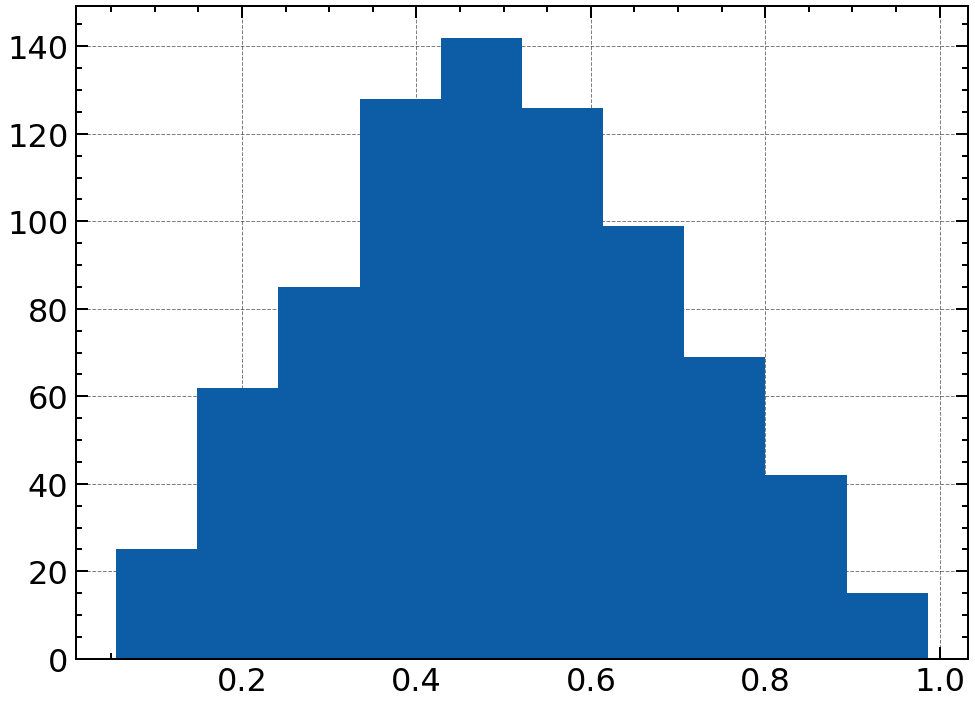

In [17]:
from torch.distributions import Normal
histogram_data = (data_tensor[:-model._order] - predictions) / model._sigma
histogram_data = Normal(0,1).cdf(histogram_data)
histogram_data = [val.item() for val in histogram_data]
plt.hist(histogram_data)
plt.show()

In [18]:
def simulate_AR_model():
    sigma = 5

    phi_1 = 0.1
    phi_2 = 0.2

    data_01 = 2.
    data_02 = 3.

    number_of_samples = 10000
    observations = []
    observations.append(data_01)
    observations.append(data_02)
    for i in range(2, number_of_samples+2):
        random = np.random.normal(0, 1, 1)
        new = phi_1 * observations[i-1] + phi_2 * observations[i-2] + sigma * random
        observations.append(new[0])
    return list(reversed(observations))

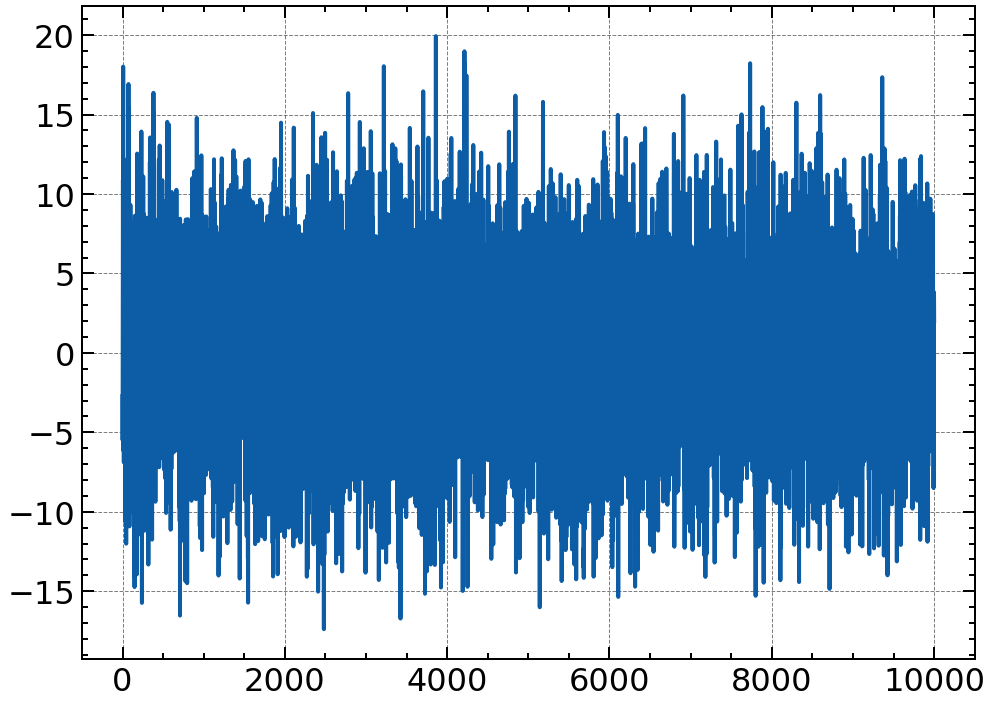

In [19]:
data = simulate_AR_model()
plt.plot(data)
plt.show()

[tensor([0.1099, 0.1906, 0.0141]), tensor(-0.0083), tensor(5.1219)]


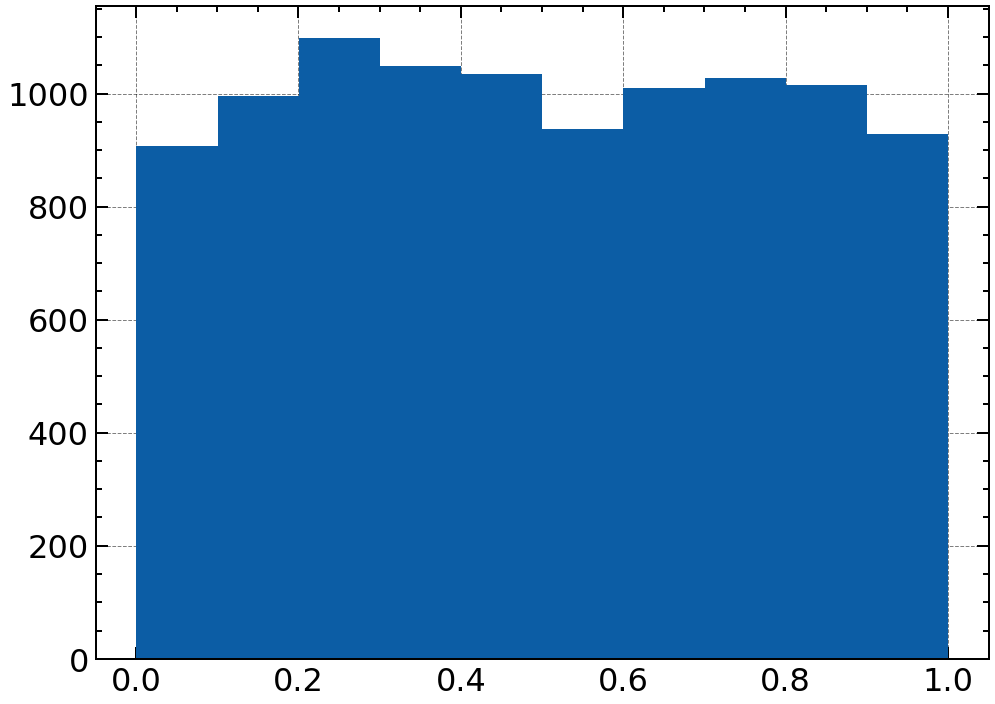

In [20]:
model = AR(pd.Series(data=data))
from torch.distributions import Normal
model.calibrate()
predictions = model._Q @ model._R @ model._solution 
residuals = model._build_residuals()
unis = Normal(0,1).cdf(residuals)
plt.hist([u.item() for u in unis])
print(model.parameters)

In [21]:
model = AR(torch.tensor(data_tensor).flip(dims=(0,)))
model.calibrate()
predictions = model._Q @ model._R @ model._phi 
residuals = model._build_residuals()
unis = Normal(0,1).cdf(residuals)
#plt.hist([u.item() for u in unis])
print(model.parameters)
plt.plot((model._Q @ model._R @ model._phi).flip(dims=(0,)))
plt.plot(data_tensor)
model.mse

/var/folders/d7/rpl_88f12ln2z1s2h4m9ybjm0000gn/T/ipykernel_43843/4159046799.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model = AR(torch.tensor(data_tensor).flip(dims=(0,)))


TypeError: new(): data must be a sequence (got builtin_function_or_method)